# Genetic Algorithm / 유전 알고리즘
*20190051 김강현*

Artificial Intelligence—as its name implies—often draws inspiration from the natural intelligence observed in humans and other animals. The **Genetic Algorithm (GA)** is a metaheuristic that takes inspiration from the process of natural selection. Genetic algorithms are widely employed to produce high-quality solutions for optimization and search problems. These algorithms rely on bio-inspired operators such as mutation, crossover, and selection to accomplish their objectives. <br>
이름으로부터 추측할 수 있듯이, 인공지능은 인간과 다른 동물들의 자연적 지능에서 영감을 받습니다. **유전 알고리즘**은 자연 선택에서 영감을 받은 것으로, 최적화 문제와 탐색 문제에 대한 높은 품질의 해결책을 찾기 위해 사용됩니다. 이 알고리즘은 돌연변이, 교배, 선택 등의 생물학적 영감을 받은 현상들을 이용한 알고리즘입니다.

In this notebook, we learn what a genetic algorithm is and how it works with an example, which goes like this:<br>
이 notebook에서는 예시를 통해 유전 알고리즘이 어떤 것이며, 어떻게 작동되는지를 살펴봅니다. 예시는 다음과 같습니다.

> "As an administrator of 10-year-long experience at KAIST, you're now in charge of **scheduling the whole courses**. You have to decide when each course is held on what days during the following semester. The course registration begins in 3 days, and you have to schedule them all and put them in the academic system database. However, there are nearly 300 courses just for undergraduate studetns and you got a lot to consider. (*There shouldn't be as many overlapping required courses as possible, basic courses are taken by students from every department, freshmen and sophomores take a different set of courses, there are quite a lot of students with a minor/double major/triple major, and so on...*) You're now in despair.<br>
> "KAIST 10년차 행정직인 당신은 이제 **카이스트 전체 강의를 스케줄링**하는 업무를 맡게 되었습니다. 한 학기동안 어떤 과목이 어떤 요일, 어떤 시간에 진행되는지를 결정하는 업무입니다. 수강 신청 기간은 3일 후에 시작되고, 모든 강의를 그 전에 스케줄링 해서 학사 시스 데이터베이스에 입력해야 합니다. 그러나, 당신은 기초/전공 필수 과목은 되도록 겹치면 안되며, 기초 과목은 전공 상관 없이 모두가 듣는 과목이고, 각 학년의 학생들은 다른 과목을 듣는 경향이 있다는 사실이 있으며, 복수 전공을 하는 학생들도 꽤 된다는 등 많은 사실들을 모두 고려하여 대략 300개에 달하는 강의를 스케줄링 해야 합니다. 어떻게 할까요?<br>
> <center><img src="KAIST_course_offered.png" alt="KAIST_course_offered.png" width="500px"></center><br>
> 
> ***But wait!*** You remember that you took an AI course in your undergraduate years. You think that you can solve this problem with a genetic algorithm. You're now ready to solve the problem."<br>
> ***아 맞다!*** 학부때 들은 AI 수업이 기억이 나기 시작했습니다. 유전 알고리즘을 이용하면 이 문제를 해결할 수 있을 것 같습니다. 이제 문제를 해결할 준비가 되었습니다."

Although there already exist deterministic algorithms that can solve this problem, they do not consider the peculiarities of KAIST mentioned above. Let's see how we can solve this problem with a genetic algorithm.<br>
이 문제를 해결할 수 있는 결정론적 알고리즘들이 이미 존재하지만, 이들은 위에서 언급한 카이스트의 특성들을 제대로 고려하진 않습니다. 유전 알고리즘을 이용해 이 문제를 어떻게 해결할 수 있는지 살펴보겠습니다.

## Scheduling courses at KAIST / 카이스트 강의 스케줄링

To get the sense of what kind of data you'll be dealing with, let's first take a look at the data. The data is stored in a csv file, and you can load it with pandas.<br>
어떤 데이터에 유전 알고리즘을 적용할지 감을 잡아보기 위해, 먼저 데이터를 살펴보겠습니다. 데이터는 csv 파일에 저장되어 있으며, pandas를 이용해 불러올 수 있습니다.

In [3]:
import pandas as pd

# read the excel file and put them into a dataframe.
KAIST_courses = pd.read_excel('courses_offered.xls')
headers = KAIST_courses.iloc[0]
KAIST_courses = pd.DataFrame(KAIST_courses.values[1:], columns=headers)

# thesis study, field practice, and individual study aren't on the time table.
exceptions = ['Thesis Study(Undergraduate)', 'Field Practice', 'Individual Study']
KAIST_courses = KAIST_courses[~(KAIST_courses['Course Type'].isin(exceptions))].groupby('Course No.', as_index=False).first()

# fix the course number format
def add_space(course_no):
    if course_no[2].isdigit():
        return course_no[:2] + ' ' + course_no[2:]
    else:
        return course_no
KAIST_courses['Course No.'] = KAIST_courses['Course No.'].apply(add_space)

print("----------------------------------")
print("You imported %d courses." % len(KAIST_courses))
print(KAIST_courses.head())

deps = set()
for course_no in KAIST_courses['Course No.']:
    if course_no[2] == ' ':
        deps.add(course_no[:2])
    else:
        deps.add(course_no[:3])
deps = sorted(list(deps))
print(deps)

----------------------------------
You imported 284 courses.
0 Course No.  year    term                           Department  \
0     AE 201  2023  Spring  Department of Aerospace Engineering   
1     AE 210  2023  Spring  Department of Aerospace Engineering   
2     AE 230  2023  Spring  Department of Aerospace Engineering   
3     AE 280  2023  Spring  Department of Aerospace Engineering   
4     AE 300  2023  Spring  Department of Aerospace Engineering   

0     Course Type Course Code Section  \
0  Major Elective      B8.201           
1  Major Required      B8.210           
2  Major Elective      B8.230           
3  Major Elective      B8.280           
4  Major Required      B8.300           

0                                   Course Title Syllabus AU  ...  \
0             Introductory Aeronautical Projects        Y  0  ...   
1                       Aerospace Thermodynamics        Y  0  ...   
2               Mechanics of Aerospace Materials        Y  0  ...   
3  Software A

You have nearly 300 courses to schedule and they have many attributes (Course No, year, term, ...). However, not all of them are important for scheduling. Here, we only consider three of them:

- **Course number**
  - e.g. CS101 consists of department + course number.
  - The first digit of a course number represents the year of the course.
  - Courses in the same year are likely to be taken by the same students.
- **Course type**:
  - Basic courses are taken by every student
  - Major courses are taken by students in the department.
- **Department**: The deparment that offers the course.

In [55]:
# Select departments
departments = ['MAS', 'CS', 'EE', 'ME', 'PH']
for i in range(len(departments)):
    if len(departments[i]) == 2:
        departments[i] = departments[i] + ' '
courses = KAIST_courses[(KAIST_courses['Course No.'].str[:3].isin(departments))]
print(courses.head())

0  Course No.  year    term           Department     Course Type Course Code  \
73     CS 101  2023  Spring  School of Computing  Basic Required      36.101   
74     CS 202  2023  Spring  School of Computing  Major Elective      36.202   
75     CS 204  2023  Spring  School of Computing  Major Required      36.204   
76     CS 206  2023  Spring  School of Computing  Major Required      36.206   
77     CS 211  2023  Spring  School of Computing  Major Elective      36.211   

0  Section                 Course Title Syllabus AU  ... Limited class size  \
73      A   Introduction to Programming        Y  0  ...                 48   
74                      Problem Solving        Y  0  ...                  0   
75                 Discrete Mathematics        Y  0  ...                  0   
76                       Data Structure        Y  0  ...                  0   
77               Digital System and Lab        Y  0  ...                 50   

0  Class size(persons)                      

# Select departments
departments = ['MAS']
for i in range(len(departments)):
    if len(departments[i]) == 2:
        departments[i] = departments[i] + ' '

These are available time slots. In KAIST, the time table on Monday and Wednesday is the same, and the time table on Tuesday and Thursday is the same.

- Mon/Wed: 09:00–10:30(0), 10:30-12:00(1), 13:00-14:30(2), 14:30-16:00(3), 16:00-17:30(4)
- Tue/Thu: 09:00–10:30(5), 10:30-12:00(6), 13:00-14:30(7), 14:30-16:00(8), 16:00-17:30(9)

A timetable of the whole course can be represented as a tuple.
For example, (0, 1, 5, 3, 9, 7, ..., 5) corresponds to one timetable, and the first course in the course table comes at 09:00 on Mondays and Wednesdays, the second course comes at 10:30 on Mondays and Wednesdays, the third course comes at 09:00 on Tuesdays and Thursdays, and so on.

# Loss function

In [56]:
def which_year(course_no):
    i = 0
    while not course_no[i].isdigit():
        i += 1
    return int(course_no[i])

course_no = list(courses['Course No.'])
course_type = list(courses['Course Type'])
course_department = list(courses['Department'])

def loss(chromosome):
    ret = 0
    for i in range(len(chromosome) - 1):
        for j in range(i + 1, len(chromosome)):
            # if in the same time slot
            if chromosome[i] == chromosome[j]:
                # same department
                if course_department[i] == course_department[j] \
                    or "Major" not in course_type[i] \
                    or "Major" not in course_type[j]:
                    # both required
                    if "required" in course_type[i] and "required" in course_type[j]:
                        department_diff = 1
                    else:
                        department_diff = 0.5
                else:
                    department_diff = 0.1
                    

                # similar year
                year_diff = ((4 - abs(which_year(course_no[i]) - which_year(course_no[j]))) / 4)**2

                # ----------
                ret += 100 * department_diff * year_diff

    return ret;

# Generic Algorithm

Generation 0
Min loss: 5117.500000
Generation 1
Min loss: 4982.500000
Generation 2
Min loss: 4911.875000
Generation 3
Min loss: 4898.125000
Generation 4
Min loss: 4859.375000
Generation 5
Min loss: 4825.000000
Generation 6
Min loss: 4746.875000
Generation 7
Min loss: 4746.875000
Generation 8
Min loss: 4688.750000
Generation 9
Min loss: 4641.250000
Generation 10
Min loss: 4641.250000
Generation 11
Min loss: 4641.250000
Generation 12
Min loss: 4596.250000
Generation 13
Min loss: 4596.250000
Generation 14
Min loss: 4596.250000
Generation 15
Min loss: 4596.250000
Generation 16
Min loss: 4586.875000
Generation 17
Min loss: 4573.125000
Generation 18
Min loss: 4573.125000
Generation 19
Min loss: 4573.125000
Generation 20
Min loss: 4573.125000
Generation 21
Min loss: 4571.250000
Generation 22
Min loss: 4571.250000
Generation 23
Min loss: 4571.250000
Generation 24
Min loss: 4543.750000
Generation 25
Min loss: 4543.750000
Generation 26
Min loss: 4543.750000
Generation 27
Min loss: 4543.750000
Ge

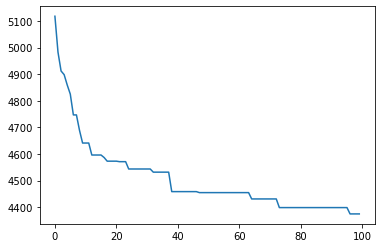

In [57]:
import numpy as np
import copy
import heapq
from matplotlib import pyplot as plt

NUM_GENERATION = 100
TOP_N = 30
NUM_MUTATION = 4
x = range(NUM_GENERATION)
y = []
CROSSOVER = True

chromosomes = [[0, np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], size=courses.shape[0])] for _ in range(10000)]

for generation in range(NUM_GENERATION):
    print("Generation %d" % generation)
    for i in range(len(chromosomes)):
        chromosomes[i][0] = loss(chromosomes[i][1])
    chromosomes.sort(key=lambda x: x[0])
    print("Min loss: %f" % chromosomes[0][0])
    y.append(chromosomes[0][0])

    if (generation == NUM_GENERATION - 1):
        break
    
    new_chromosomes = chromosomes[:TOP_N]

    if CROSSOVER:
        # crossover of TOP_N
        for i in range(TOP_N - 1):
            for j in range(i + 1, TOP_N):
                chromosome1 = chromosomes[i][1]
                chromosome2 = chromosomes[j][1]
                new_chromosome = copy.deepcopy(chromosome1)
                template = 0
                crossover_points = np.random.choice(range(len(new_chromosome)), size=2, replace=False)
                for k in range(len(new_chromosome)):
                    if k in crossover_points:
                        template = 1 - template
                    if template == 0:
                        new_chromosome[k] = chromosome1[k]
                    else:
                        new_chromosome[k] = chromosome2[k]
                    rand = np.random.rand()
                    if rand < 0.1:
                        new_chromosome[k] = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
                new_chromosomes.append([0, new_chromosome])
            
    chromosomes = new_chromosomes

plt.plot(x, y)

# Optimized Timetables

In [52]:
optimized_tuple = chromosomes[0][1]
time = {0: "09:00-10:30 on Mon&Wed", 1: "10:30-12:00 on Mon&Wed", 2: "13:00-14:30 on Mon&Wed", 3: "14:30-16:00 on Mon&Wed", 4: "16:00-17:30 on Mon&Wed", 5: "09:00-10:30 on Tue&Thu", 6: "10:30-12:00 on Tue&Thu", 7: "13:00-14:30 on Tue&Thu", 8: "14:30-16:00 on Tue&Thu", 9: "16:00-17:30 on Tue&Thu"}
time_table_of_departments_by_year = dict()
for department in departments:
    time_table_of_departments_by_year[department] = [[[] for _ in range(10)] for _ in range(4)]
    
for i in range(len(optimized_tuple)):
    time_table_of_departments_by_year[course_no[i][:3]][int(course_no[i][3])-1][optimized_tuple[i]].append(course_no[i])

for department in departments:
    print(department)
    for i in range(10):
        print(time[i], end=': ')
        for year in range(4):
            for course in time_table_of_departments_by_year[department][year][i]:
                print(course, end=' ')
        print()

MAS
09:00-10:30 on Mon&Wed: MAS275 
10:30-12:00 on Mon&Wed: MAS350 
13:00-14:30 on Mon&Wed: MAS210 
14:30-16:00 on Mon&Wed: MAS109 MAS311 
16:00-17:30 on Mon&Wed: MAS331 
09:00-10:30 on Tue&Thu: MAS341 
10:30-12:00 on Tue&Thu: MAS241 
13:00-14:30 on Tue&Thu: MAS102 MAS201 MAS250 
14:30-16:00 on Tue&Thu: MAS212 
16:00-17:30 on Tue&Thu: MAS101 MAS110 
CS 
09:00-10:30 on Mon&Wed: CS 230 CS 311 
10:30-12:00 on Mon&Wed: CS 300 CS 341 
13:00-14:30 on Mon&Wed: CS 204 CS 361 
14:30-16:00 on Mon&Wed: CS 202 CS 374 
16:00-17:30 on Mon&Wed: CS 270 CS 376 CS 493 
09:00-10:30 on Tue&Thu: CS 206 CS 348 
10:30-12:00 on Tue&Thu: CS 360 CS 372 
13:00-14:30 on Tue&Thu: CS 101 CS 350 
14:30-16:00 on Tue&Thu: CS 320 CS 380 
16:00-17:30 on Tue&Thu: CS 211 CS 330 
EE 
09:00-10:30 on Mon&Wed: EE 214 EE 303 EE 312 
10:30-12:00 on Mon&Wed: EE 204 EE 323 EE 469 
13:00-14:30 on Mon&Wed: EE 209 EE 305 
14:30-16:00 on Mon&Wed: EE 321 EE 405 
16:00-17:30 on Mon&Wed: EE 210 EE 352 
09:00-10:30 on Tue&Thu: EE 341 EE 

In [53]:
# histogram slide through departments
from ipywidgets import interact
@interact(department=departments)

def histogram(department=departments):
    x = range(10)
    bottom = [0 for _ in range(10)]
    for year in range(4):
        y = [len(time_table_of_departments_by_year[department][year][i]) for i in range(10)]
        # same year at the same height
        plt.bar(x, y, bottom=bottom)
        bottom = [bottom[i] + max(y) for i in range(10)]
    plt.xticks(x, [time[i] for i in range(10)], rotation=45)
    plt.title(department)
    plt.legend(['1st year', '2nd year', '3rd year', '4th year'])
    plt.show()

    

interactive(children=(Dropdown(description='department', options=('MAS', 'CS ', 'EE ', 'ME ', 'PH '), value='M…